# Binary LSTM classification model V2

In this notebook, we've improved upon the original binary LSTM model for the DGA/non-DGA classification of a domain name; from the Endgame paper.

"Predicting Domain Generation Algorithms with Long Short-Term Memory Networks"
http://arxiv.org/abs/1611.00791v1

The original model is demonstrated in *Model_LSTM_binary.ipynb*

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.preprocessing import sequence
from keras.preprocessing import text

from tensorflow.python.client import device_lib

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Check if gpu can be utilized for acceleration
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4898596617457371600
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351067136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13204546765646123260
physical_device_desc: "device: 0, name: GeForce GTX 780M, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


In [3]:
# Path and file variables for saving model information
path_dir = '.\\saved_models\\v2\\'
name_encoder      = path_dir + 'binary_tokenizer.pkl'
name_model        = path_dir + 'binary_LSTM.json'
name_weights      = path_dir + 'binary_LSTM.h5'
name_categories   = path_dir + 'binary_categories.pkl'

# Category names
name_DGA = 'DGA'
name_nonDGA = 'non-DGA'

In [4]:
# Read DGA and Cisco high confidence data
dga_df = pd.read_csv('..\\data\\2018_0923\\dga-feed-high.csv', header=None, skiprows=15)
cisco_df = pd.read_csv('..\\data\\2018_0923\\top-1m.csv', header=None)

In [5]:
# display head
def display_df(dga_df_, cisco_df_):
    display("DGA feed sample: {}".format( dga_df_.shape) )
    display(dga_df_.head())
    display("Cisco feed sample: {}".format( cisco_df_.shape) )
    display(cisco_df_.head())

In [6]:
# Remove unused columns, add output label 'dga'

dga_df_slim =   dga_df.drop(columns=range(1,dga_df.shape[1]), inplace=False)
dga_df_slim.columns = ['domain']
cisco_df_slim = cisco_df.drop(columns=[0], inplace=False)
cisco_df_slim.columns = ['domain']
dga_df_slim['dga'] = name_DGA
cisco_df_slim['dga'] = name_nonDGA

display_df(dga_df_slim, cisco_df_slim)
unified_df = pd.concat([cisco_df_slim, dga_df_slim], ignore_index=True)
unified_df['dga'], labels = pd.factorize(unified_df['dga'], sort=True)   # binary factorization and potentially realigning the DGA categories
with open(name_categories, 'wb') as catEnc:
    pickle.dump(labels, catEnc, protocol=pickle.HIGHEST_PROTOCOL)

'DGA feed sample: (381953, 2)'

,domain,dga
0,plvklpgwivery.com,DGA
1,dnuxdhcgblsgy.net,DGA
2,qjlullhfkiowp.biz,DGA
3,elkidddodxdly.ru,DGA
4,rnbfwuprlwfor.org,DGA


'Cisco feed sample: (1000000, 2)'

,domain,dga
0,netflix.com,non-DGA
1,api-global.netflix.com,non-DGA
2,prod.netflix.com,non-DGA
3,push.prod.netflix.com,non-DGA
4,google.com,non-DGA


In [7]:
# Separate input sequences (domains) and output labels (DGA 0/1), and do train/test split

X = unified_df['domain']
Y = unified_df['dga']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=23)

In [8]:
# Loss plotting function
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r',
        3 : 'o',
        4 : 'p'
    }
    
    for i, hist in enumerate(hists):
        plt.plot(hist['loss'], color=colordict[i], label="training " + names[i])
        plt.plot(hist['val_loss'], color=colordict[i], linestyle='--', label="validation " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

In [18]:
# Binary classification LSTM model
# NOTE - model training is very time consuming. 
#        Set the TRAIN_MODEL to False before running this cell.

TRAIN_MODEL = True                                          # Load saved model otherwise
num_epochs = 10                                             # epochs to train

max_features = 1000                                         # length of vocabulary
batch_size = 128                                            # input batch size
max_seq_len = 100                                           # maximum char length of domain name
embed_size = 256                                            # embedding vector length
drop_rate = 0.5                                             # dropout rate - fraction of layers to drop
val_split = 0.1                                             # fraction of training data to use for validation

if TRAIN_MODEL != True:
    file = open(name_model, 'r')
    model_load = file.read()
    file.close()
    model = model_from_json(model_load)
    model.load_weights(name_weights)
    with open(name_encoder, 'rb') as tokenEnc:
        encoder = pickle.load(tokenEnc)
    with open(name_categories, 'rb') as catEnc:
        labels = pickle.load(catEnc)
    print('SKIPPED MODEL TRAINING.\nSAVED MODEL IS NOW LOADED!')

else:                                                        # train the model
    # encode string characters to integers
    encoder = text.Tokenizer(num_words=500, char_level=True)
    encoder.fit_on_texts(X_train)                            # build character indices
    X_train_tz = encoder.texts_to_sequences(X_train)
    
    # Model definition - this is the core model from Endgame
    model=Sequential()
    model.add(Embedding(max_features, embed_size, input_length=max_seq_len))
    model.add(LSTM(embed_size))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    print("\nMODEL SUMMARY:")
    print(model.summary())
    
    # Pad sequence where sequences are case insensitive characters encoded to
    # integers from 0 to number of valid characters
    X_train_pad=sequence.pad_sequences(X_train_tz, maxlen=max_seq_len)
    
    # Training
    model_hist = model.fit(X_train_pad, Y_train, batch_size=batch_size, epochs=num_epochs, validation_split=val_split)


MODEL SUMMARY:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 256)          256000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 781,569
Trainable params: 781,569
Non-trainable params: 0
_________________________________________________________________
None
Train on 995005 samples, validate on 110557 samples
Epoch 1/10
995005/995005 [==============================] - 272

Metrics to be plotted:  dict_keys(['val_loss', 'loss'])


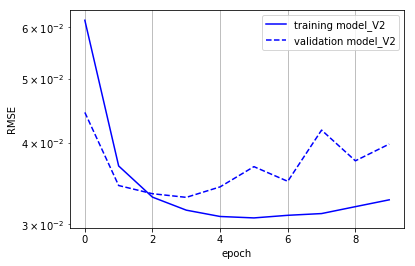

In [19]:
# plot model losses vs. epocs to inspect underfitting/overfitting

if (TRAIN_MODEL == True) and (val_split != 0.0) and (num_epochs > 1):
    print("Metrics to be plotted: ", model_hist.history.keys())
    plot_loss([model_hist.history], ['model_V2'])

In [15]:
# Validation on test dataset
# Compute prediction probabilities of classes 

X_test_pad = sequence.pad_sequences(encoder.texts_to_sequences(X_test), maxlen=max_seq_len)
Y_pred1_prob = model.predict(X_test_pad)
Y_pred_prob = np.hstack([1-Y_pred1_prob, Y_pred1_prob])   # in using sigmoid, the output probability is of class 1
Y_pred = np.argmax(Y_pred_prob, axis=1)
acc = accuracy_score(Y_test, Y_pred)
print("Model accuracy = {:8.3f} %".format(acc*100))

Model accuracy =   98.989 %


In [20]:
# Inspect a few prediction probabilities

pred_table = X_test.to_frame()
pred_table.columns = ['domain']
pred_table['trueClass'] = [labels[i] for i in Y_test]
pred_table['predClass'] = [labels[i] for i in Y_pred]
pred_table['predProb'] = [Y_pred_prob[idx][Y_pred[idx]] for idx in range(0, Y_pred.shape[0]) ]

print('\nCorrectly predicted Domains:')
display(pred_table[pred_table['trueClass'] == pred_table['predClass'] ].head(10) )

print('\nMis-predicted Domains:')
display(pred_table[pred_table['trueClass'] != pred_table['predClass'] ].head(10) )


pred_table_FP = pred_table[(pred_table['trueClass'] == name_nonDGA) & (pred_table['predClass'] == name_DGA) ]
print('\nPercentage of False Positives (i.e. nonDGA domains classified as DGA): {:6.4f} %'
      .format(100*pred_table_FP.shape[0]/pred_table.shape[0]))
pred_table_FN = pred_table[(pred_table['trueClass'] == name_DGA) & (pred_table['predClass'] == name_nonDGA) ]
print('\nPercentage of False Negatives (i.e. DGA domains classified as nonDGA): {:6.4f} %'
      .format(100*pred_table_FN.shape[0]/pred_table.shape[0]))


Correctly predicted Domains:


,domain,trueClass,predClass,predProb
124546,ns47.domaincontrol.com,non-DGA,non-DGA,1.000000
660921,britishlibrary.typepad.co.uk,non-DGA,non-DGA,1.000000
446456,a538.casalemedia.com,non-DGA,non-DGA,1.000000
600919,ign-ar8de21s8pinm-8d3d0d118-4d8d69dgoogleplayd...,non-DGA,non-DGA,1.000000
1186650,gbggekvj.eu,DGA,DGA,0.989490
115543,ewr-66.ewr-rtb1.rfihub.com,non-DGA,non-DGA,1.000000
1360357,vsagkcaahpxrfbmqljnnxutj.com,DGA,DGA,0.999835
464912,static.bladeandsoul.com,non-DGA,non-DGA,1.000000
1097547,dlpyniywfxxp.com,DGA,DGA,0.999893
606453,trans11212.addressy.com,non-DGA,non-DGA,1.000000



Mis-predicted Domains:


,domain,trueClass,predClass,predProb
894708,msfncsi.com,non-DGA,DGA,0.676012
90390,6htb5ck86hk8i9.com,non-DGA,DGA,0.758457
610853,wvxlsagkeuye.ir,non-DGA,DGA,0.958879
1259769,gsilnc.net,DGA,non-DGA,0.707120
1376705,lyryrirc.com,DGA,non-DGA,0.509891
655678,1bxencbsmr.ddns.net,non-DGA,DGA,0.999999
1227223,ycarusapao.com,DGA,non-DGA,0.742062
408848,h83zvgrg29.com,non-DGA,DGA,0.992546
961259,idiidowowowofjgjgisos.su,non-DGA,DGA,0.979731
1302961,bilvdat.me,DGA,non-DGA,0.713395



Percentage of False Positives (i.e. nonDGA domains classified as DGA): 0.7135 %

Percentage of False Negatives (i.e. DGA domains classified as nonDGA): 0.2970 %


In [17]:
# Save model and weights
if TRAIN_MODEL == True:
    model_save = model.to_json()
    with open(name_model, 'w') as file:
        file.write(model_save)
    model.save_weights(name_weights)
    with open(name_encoder, 'wb') as tokenEnc:
        pickle.dump(encoder, tokenEnc, protocol=pickle.HIGHEST_PROTOCOL)
    print('MODEL SAVED TO DISK!')
else:
    print('MODEL AREADY SAVED TO DISK.')

MODEL SAVED TO DISK!


## Look ahead and next steps:
__1__ Look closer at the misclassified domains. Any particular DGA category stands out? What do we need to improve? 

__2__ Improving classification accuracy - more balanced dataset especially for the multiclass classification.

__3__ Learning from scratch takes significant time. Need to implement model update in batches of new domain dataset.

__4__ Modify the model to do multiclass classification across the various DGA categories. Do we need to trim down the categories - dataset shows 60+ categories and new ones may be added any time.